# Detecting lines and circles using the Hough transform

In this recipe, you will learn how to apply the Hough transform for the detection of lines and circles. This is a helpful technique when you need to perform basic image analysis and find primitives in images.

The Hough transform is a technique for the detection of any shapes parametrized and represented in a convenient mathematical form. Basically, for every pixel in a source image, the Hough transform finds a set of model parameters that satisfy the observation and stores them in table. Each pixel votes for a subset of possible models. Output detections are obtained via a voting procedure.

The detection of lines is implemented in the function `cv2.HoughLineP`. In fact, it does not implement the original Hough transform, but its optimized, probabilistic version. The function takes parameters such as the source image, voting space spatial resolution, voting space angular resolution, minimum votes threshold, minimum line length, and maximum allowed gap between points on the same line to link them, and returns a list of detected lines represented in a `start_point`, `end_point` form.

The detection of circles is implemented in the function `cv2.HoughCircles`. It takes the input source image, detection method (only `cv2.HOUGH_GRADIENT` is supported, for now), inverse voting space resolution, minimum distance between the centers of detected circles, and two optional parameters: the first is the higher threshold for the Canny edge detection procedure, and the second is the votes count threshold.



In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

%matplotlib auto
%pylab inline


def print_image(header,name,np_arr,start_First=0, end_First=1, start_Second=0, end_Second=2):
    print("------  {0:-<25}    Shape{1} {2}: {3:}".format(header, np_arr.shape, name, str(np_arr.dtype)) )
    shapes = np_arr.shape #print(shapes)
    if shapes[0] < end_First:
        end_First = shapes[0]
    if shapes[1] < end_Second:
        end_Second = shapes[1]
    if len(shapes)==3:
        for i in range (start_First,end_First):
            print("[", end=" ")
            for k in range (start_Second,end_Second):
                print(np_arr[i,k], end=" ")
            print(']')
    if len(shapes)==2:
        for i in range (start_First,end_First):
            print("[", end=" ")
            for k in range (start_Second,end_Second):
                print(np_arr[i,k], end=" ")
            print(']')
def plt_view_image(plt,list_images,figsize=(15,6), axis="off", cmap='gray'):
    #%pylab inline
    plt.figure(figsize=figsize)
    n = len(list_images)  #; print(n)
    plot_number = 1
    for name, img in list_images:
        plt.subplot(1,n,plot_number)
        plt.axis(axis)
        plt.title(name)
        if cmap =='gray':
            plt.imshow(img,cmap='gray' )
        else:
            plt.imshow(img )
        plot_number = plot_number + 1
    plt.show()
#help("modules")   
import sys             
print('\n'.join(sys.path))
#pip list"

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib
D:\HTML_DOC\Program\opencv\Packt\S04\env
C:\Program Files\Python38\python38.zip
C:\Program Files\Python38\DLLs
C:\Program Files\Python38\lib
C:\Program Files\Python38
d:\html_doc\program\opencv\packt\s04\env

d:\html_doc\program\opencv\packt\s04\env\lib\site-packages
d:\html_doc\program\opencv\packt\s04\env\lib\site-packages\pip-20.0.2-py3.8.egg
d:\html_doc\program\opencv\packt\s04\env\lib\site-packages\win32
d:\html_doc\program\opencv\packt\s04\env\lib\site-packages\win32\lib
d:\html_doc\program\opencv\packt\s04\env\lib\site-packages\Pythonwin
d:\html_doc\program\opencv\packt\s04\env\lib\site-packages\IPython\extensions
C:\Users\polit\.ipython


# [Преобразование Хафа](https://ru.wikipedia.org/wiki/%D0%9F%D1%80%D0%B5%D0%BE%D0%B1%D1%80%D0%B0%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%A5%D0%B0%D1%84%D0%B0)

При автоматизированном анализе цифровых изображений очень часто возникает проблема идентификации простых фигур, таких как прямые, круги или эллипсы. Во многих случаях используется алгоритм поиска границ в качестве предобработки для получения точек, находящихся на кривой в изображении. Однако, либо из-за зашумлённости изображения, либо из-за несовершенства алгоритма обнаружения границ, могут появиться «потерянные» точки на кривой, также как и небольшие отклонения от идеальной формы прямой, круга или эллипса. По этим причинам часто довольно сложно приписать найденные границы соответствующим прямым, кругам и эллипсам в изображении. Назначение преобразования Хафа — разрешить проблему группировки граничных точек путём применения определённой процедуры голосования к набору параметризованных объектов изображения.

In [2]:
# Draw a test image
img = np.zeros((500, 500), np.uint8)
cv2.circle(img, (200, 200), 50, 255, 6)
cv2.line(img, (100, 400), (400, 350), 255, 6)

print_image('img','img',img,200,201,231,272)

------  img----------------------    Shape(500, 500) img: uint8
[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 255 255 255 255 255 255 255 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ]


# [Реализация поиска печатей на OpenCV без нейронок, регистрации и смс](https://habr.com/ru/company/directum/blog/486476/)

Если вы думаете, что этого может быть достаточно, то я скажу вам, что нет. Хотя для большинства случаев этого будет более чем хватать. Но если вы хотите больше точности — устройтесь поудобней, у меня есть еще один метод.

В данном методе на помощь нам приходит щепотка “математической магии”, а именно перевод из одной системы координат в другую, конкретно в логарифмическую-полярную систему. Я могу понять удивление некоторых “чем это вообще может помочь”? С помощью этого мы “выворачиваем” печать. Но зачем? Это легко позволяет понять, является ли что-то на объекте круглым.

In [3]:
#https://habr.com/ru/company/directum/blog/486476/

# Detect circles using the Hough transform
#cv2.HoughCircles(image, method, dp, minDist[, circles[, param1[, param2[, minRadius[, maxRadius]]]]]) -> circles
# image - маска, полученная после сегментации;
# method - метод поиска окружностей (в OpenCV реализован только Gradient);
# dp - разрешение, используемое для детектирования центров кругов (1 — одинаково с исходным изображением, 2 — половина высоты/ширины и т.д. Чем ниже это значение (т.е. выше разрешение), тем больше “голосов” нужно отдать какому-либо объекту, чтобы принять его за круг. Это повышает точность, но плохо “пропечатанные” окружности могут не найтись);
# minDist - минимальное расстояние между окружностями (мы брали % от ширины изображения);
# param1 - верхнее пороговое значение, передаваемое детектору границ Кенни (нижнее пороговое значение будет в 2 раза меньше);
# param2 - суммирующее пороговое значение детектированя центров;
# minRadius - минимальный радиус круга;
# maxRadius - максимальный радиус круга;
circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, 15, param1=200, param2=30)[0]
print(circles)

[[198.5 203.5  49.8]]


In [4]:
# Detect lines using the probabilistic Hough transform
#cv2.HoughLinesP(image, rho, theta, threshold[, lines[, minLineLength[, maxLineGap]]]) -> lines
# rho — разрешение по дистанции
# theta — разрешение по углу (в радианах)
# threshold — пороговый параметр. Линия возвращается, если аккумулирующий параметр больше порогового значения.
# minLineLength – Minimum line length. Line segments shorter than that are rejected.
# maxLineGap – Maximum allowed gap between points on the same line to link them.
# param1 — первый параметр (в зависимости от метода трансфрмации:
# CV_HOUGH_STANDARD — 0 — не используется
# CV_HOUGH_PROBABILISTIC — минимальная длина линии
# CV_HOUGH_MULTI_SCALE — делитель разрешения по дистанции (rho/param1))
# param2 — второй параметр (в зависимости от метода трансфрмации:
# CV_HOUGH_STANDARD — 0 — не используется
# CV_HOUGH_PROBABILISTIC — максимальный промежуток между сегментами линии, лежащими на одной линии, чтобы считать их одним сегментом (объединить их вместе)
# CV_HOUGH_MULTI_SCALE — делитель разрешения по углу (theta/param1))
lines = cv2.HoughLinesP(img, 1, np.pi/180, 100, 100, 10)[0]
print(lines)

[[ 98 401 400 347]]


In [5]:
# Draw the detected lines and circles
dbg_img = np.zeros((img.shape[0], img.shape[1], 3), np.uint8)    

cv2.circle(dbg_img, (200, 200), 50, (255,255,255), 10)
cv2.line(dbg_img, (100, 400), (400, 350), (255,255,255), 10);


for x1, y1, x2, y2 in lines:
    print('Detected line: ({} {}) ({} {})'.format(x1, y1, x2, y2))
    cv2.line(dbg_img, (x1, y1), (x2, y2), (0, 255, 0), 2)    

for c in circles:
    print('Detected circle: center=({} {}), radius={}'.format(c[0], c[1], c[2]))
    cv2.circle(dbg_img, (c[0], c[1]), c[2], (0, 255, 0), 2)

Detected line: (98 401) (400 347)
Detected circle: center=(198.5 203.5), radius=49.79999923706055


<ipython-input-5-33144470443d>:14: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.circle(dbg_img, (c[0], c[1]), c[2], (0, 255, 0), 2)


------  img----------------------    Shape(500, 500) img: uint8
[ 0 0 255 255 255 255 255 255 255 0 0 0 0 0 ]
------  dbg_img------------------    Shape(500, 500, 3) dbg_img: uint8
[ [255 255 255] [  0 255   0] [  0 255   0] [  0 255   0] [255 255 255] [255 255 255] [255 255 255] [255 255 255] [255 255 255] [255 255 255] [255 255 255] [0 0 0] [0 0 0] [0 0 0] ]


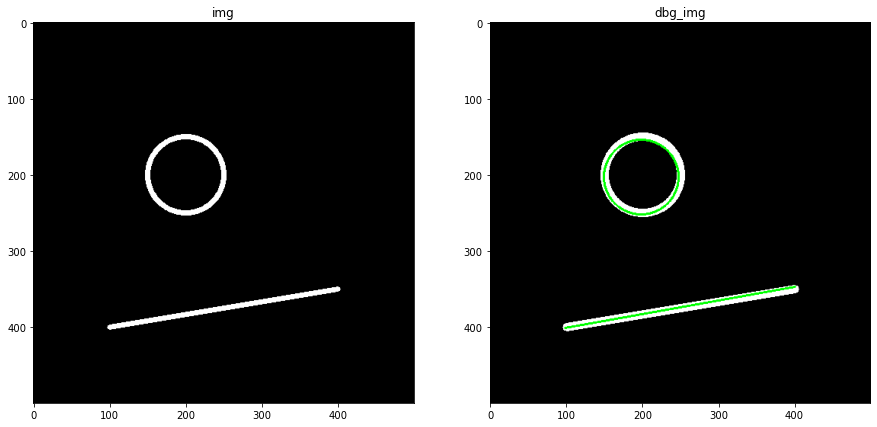

In [6]:
print_image('img','img',img,200,201,245,259)
print_image('dbg_img','dbg_img',dbg_img,200,201,245,259)

# Visualize the results
plt_view_image(plt,[["img",img],
                    ["dbg_img",dbg_img]
                   ],
               figsize=(15,15), axis='on', cmap='gray'
              )


cv2.imshow('img',img)
cv2.imshow('dbg_img',dbg_img)
cv2.waitKey()
cv2.destroyAllWindows()